In [1]:
#  Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
import lzma
import pickle

In [5]:
with lzma.open("../data/pitches.xz", "rb") as f:
    pitches = pickle.load(f)

In [6]:
#  View data
pitches.head()

,vx0,vy0,vz0,release_speed,release_spin_rate,pfx_x,pfx_z,plate_x,plate_z,ax,...,sz_bot,pitch_type,player_name,pitch_no,ball,swing,called,foul,out,hit
3295,4.974465,-120.970548,-1.590698,83.1,2275,0.57,-0.13,-0.19,2.35,4.535602,...,1.52,SL,"Romano, Jordan",1,0,0,0,0,1,0
3404,6.550197,-122.185723,-2.165955,84.0,2284,0.46,-0.13,0.13,1.99,3.33423,...,1.52,SL,"Romano, Jordan",2,0,0,1,0,0,0
3519,8.688477,-126.547267,-4.968054,87.1,2224,0.46,-0.26,0.95,1.07,3.120242,...,1.52,SL,"Romano, Jordan",3,1,0,0,0,0,0
3629,8.199169,-140.755107,-5.791813,96.9,2440,-0.01,1.61,0.17,3.2,-1.983056,...,1.58,FF,"Romano, Jordan",4,0,1,0,0,0,0
3702,7.799187,-136.869501,-4.917298,94.2,2353,-0.22,1.55,-0.5,3.01,-4.529335,...,1.58,FF,"Romano, Jordan",5,0,1,0,0,0,0


In [7]:
#  View columns
pitches.columns

Index(['vx0', 'vy0', 'vz0', 'release_speed', 'release_spin_rate', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'ax', 'ay', 'az', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'vz0*2', 'pfx_z*2', 'plate_z*2',
       'p_throws', 'starter', 'sz_top', 'sz_bot', 'pitch_type', 'player_name',
       'pitch_no', 'ball', 'swing', 'called', 'foul', 'out', 'hit'],
      dtype='object')

In [8]:
#  Check again for nulls
pitches.isnull().sum().sum()

0

In [9]:
X = pitches.drop(columns = 'pitch_no')

#  Square root transformation to normalize data 
## more effective at normalization than log-transform for this dataset
y = pd.DataFrame([x ** 0.5 for x in pitches['pitch_no']])

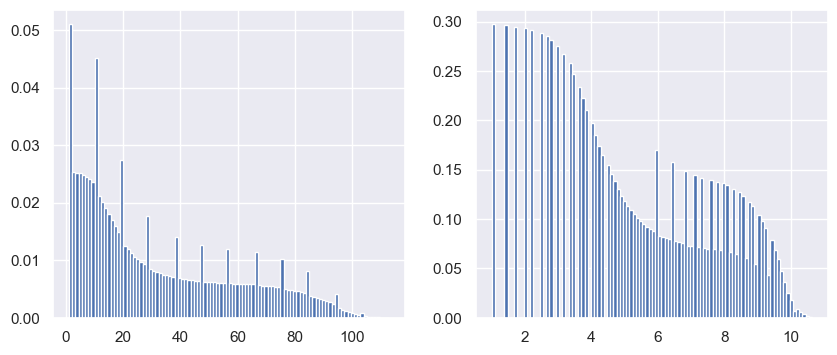

In [31]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].hist(pitches['pitch_no'],bins = 100, density = True)
axs[1].hist((pitches['pitch_no'] ** 0.5),bins = 100, density = True);

In [11]:
#  Preserve dummified columns for later processing
X['pitch_type_orig'] = X['pitch_type']
X['player_name_orig'] = X['player_name']

In [12]:
#  Dummify pitch type and pitcher name (only categorical columns in remaining data)
X = pd.get_dummies(X, columns = ['pitch_type','player_name'])

In [13]:
#  Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
pitches.columns

Index(['vx0', 'vy0', 'vz0', 'release_speed', 'release_spin_rate', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'ax', 'ay', 'az', 'release_pos_x',
       'release_pos_y', 'release_pos_z', 'vz0*2', 'pfx_z*2', 'plate_z*2',
       'p_throws', 'starter', 'sz_top', 'sz_bot', 'pitch_type', 'player_name',
       'pitch_no', 'ball', 'swing', 'called', 'foul', 'out', 'hit'],
      dtype='object')

In [15]:
#  Generating new features
for col in pitches.columns[:-12]: 
    
    # get avg metrics from train data by player and pitch type
    X_train[f'{col}_avg'] = X_train.groupby(['player_name_orig','pitch_type_orig'])[col].transform('mean')
    
    # store averages in a variable
    avgs = X_train.groupby(['player_name_orig', 'pitch_type_orig'])[col].mean().reset_index()
    
    # merge averages onto test data 
    merge = X_test.merge(avgs, on = ['player_name_orig','pitch_type_orig'], how = 'left')
    X_test[f'{col}_avg'] = merge[col + '_y']
    
    # create new columns for differential from train avg in both train and test data
    X_train[f'{col}_diff'] = X_train[col] - X_train[f'{col}_avg']
    X_test[f'{col}_diff'] = X_test[col] - X_test[f'{col}_avg']    
    

In [16]:
#  Drop categorical columns now that they have been dummified and used for grouped avgs
X_train.drop(columns = ['player_name_orig', 'pitch_type_orig'], inplace = True)
X_test.drop(columns = ['player_name_orig', 'pitch_type_orig'], inplace = True)

In [17]:
#  Check again for nulls
X_train.isnull().sum().sum()

0

In [18]:
X_test.isnull().sum().sum()

494

In [19]:
#  The merge above created nulls in X_test, but not in X_test
#  Combine X_test and y_test to drop indices of nulls

X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
combined = pd.concat([X_test, y_test], axis = 1)
combined.dropna(inplace = True)
X_test = combined.iloc[:,:-1]
y_test = combined.iloc[:,-1]

In [20]:
# Check shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((107897, 629), (35953, 629), (107897, 1), (35953,))

In [21]:
#  Reshape y_train 
y_train = y_train.squeeze()

In [22]:
# Rescale and reshape as df
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [23]:
X_train = pd.DataFrame(X_train, columns = ss.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = ss.get_feature_names_out())

In [24]:
#  Compress large-width X dfs and save to data folder 
with lzma.open("../data/X_train.xz", "wb") as f:
    pickle.dump(X_train, f)
with lzma.open("../data/X_test.xz", "wb") as f:
    pickle.dump(X_test, f)

In [25]:
#  Write single-column y dfs to data folder as csv
y_train.to_csv('../data/y_train.csv',index = False)
y_test.to_csv('../data/y_test.csv', index = False)

In [26]:
# save scaler to app folder
pickle.dump(ss, open('../app/scaler.pkl', 'wb'))